In [15]:
import numpy as np
import xarray as xr 
from scipy.interpolate import interp1d
import gsw
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
import cmocean as cmo
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [3]:
stations = ['SO', 'ArgB', 'Irm', 'PAPA']
sta_lon = [360-89.24, 360-42.4985, 360-39.4818, 360 - 145.398]
sta_lat = [-54.47, -42.98167, 59.9753, 50.3]

In [4]:
# -- start at the beginning 
f_argo_s = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Salinity_2019.nc'
f_argo_t = '/Users/jakesteinberg/Documents/CPT/Argo/RG_climatology/RG_ArgoClim_Temperature_2019.nc'
argo_s = xr.open_dataset(f_argo_s,decode_times=False)
argo_t = xr.open_dataset(f_argo_t,decode_times=False)
RGlon = argo_s.LONGITUDE.data
RGlat = argo_s.LATITUDE.data
RGz = gsw.z_from_p(argo_s.PRESSURE.data, 45) 
# note: just choosing some lat (error due to this = the second decimal place in depth units... in the upper 1000m)
# shift RG, MLD by longitude 
# RG_shift = np.where(RGlon > 360)[0]
# RGlon = np.concatenate((np.arange(0.5,20.5,1), RGlon[0:RG_shift[0]]))

In [5]:
argo_s.ARGO_SALINITY_ANOMALY

<xarray.DataArray 'ARGO_SALINITY_ANOMALY' (TIME: 180, PRESSURE: 58, LATITUDE: 145, LONGITUDE: 360)>
[544968000 values with dtype=float32]
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * LATITUDE   (LATITUDE) float32 -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * PRESSURE   (PRESSURE) float32 2.5 10.0 20.0 30.0 ... 1800.0 1900.0 1975.0
  * TIME       (TIME) float32 0.5 1.5 2.5 3.5 4.5 ... 176.5 177.5 178.5 179.5
Attributes:
    units:      Practical Salinity Scale 78
    long_name:  ARGO SALINITY ANOMALY defined by Jan 2004 - Dec 2018 (15.0 ye...

In [16]:
168/12 + 2004

2018.0

In [6]:
RG_shift = np.where(RGlon > 360)[0][0]
RGlon_c = np.concatenate([RGlon[0:RG_shift], np.arange(0.5,RGlon[0],1)])
t_indices = [168,180]
p_i = np.tile(argo_s.PRESSURE.data[:,None,None],(1,len(argo_s.LATITUDE),len(RGlon_c)))
lon_i = np.tile(RGlon_c[None,None,:],(len(argo_s.PRESSURE),len(argo_s.LATITUDE),1))
lat_i = np.tile(argo_s.LATITUDE.data[None,:,None],(len(argo_s.PRESSURE.data),1,len(RGlon_c)))
N2 = np.nan * np.ones(np.shape(argo_s.ARGO_SALINITY_ANOMALY[t_indices[0]:t_indices[-1]][:,1:]))
SA = np.nan * np.ones(np.shape(argo_s.ARGO_SALINITY_ANOMALY[t_indices[0]:t_indices[-1]]))
CT = np.nan * np.ones(np.shape(argo_s.ARGO_SALINITY_ANOMALY[t_indices[0]:t_indices[-1]]))
density = np.nan * np.ones(np.shape(argo_s.ARGO_SALINITY_ANOMALY[t_indices[0]:t_indices[-1]]))
count = 0
for m in tqdm(range(t_indices[0],t_indices[-1])):
    s = argo_s.ARGO_SALINITY_MEAN + argo_s.ARGO_SALINITY_ANOMALY[m]
    t = argo_t.ARGO_TEMPERATURE_MEAN + argo_t.ARGO_TEMPERATURE_ANOMALY[m]
    sa = gsw.SA_from_SP(s, p_i, lon_i, lat_i)
    ct = gsw.CT_from_t(s, t, p_i)
    [N2_i, p_N] = gsw.Nsquared(sa, ct, p_i, lat_i)
    N2[count] = N2_i
    # SA_func = interp1d(argo_s.PRESSURE.data, sa, axis=0)
    # CT_func = interp1d(argo_s.PRESSURE.data, ct, axis=0)
    SA[count] = sa # SA_func(p_N)
    CT[count] = ct # CT_func(p_N)
    density[count] = gsw.sigma0(sa, ct)
    count = count + 1


In [7]:
# sum of squared seasonal amplitude
tot_var = np.nansum((np.nanmax(density, axis=0) - np.nanmin(density, axis=0))**2,axis=0) 

In [8]:
# cumulative sum of seasonal amplitude at each depth 
dep_var = np.cumsum((np.nanmax(density, axis=0) - np.nanmin(density, axis=0))**2,axis=0)

In [9]:
dep_seas = np.nan*np.ones((np.shape(density)[2], np.shape(density)[3]))
for i in tqdm(range(np.shape(density)[2])):
    for j in range(np.shape(density)[3]):
        if tot_var[i,j] > 0:
            dep_seas[i,j] = RGz[np.where(dep_var[:,i,j] > 0.9*tot_var[i,j])[0][0]]

In [10]:
# bathy
import scipy.io as sio
H = sio.loadmat('/Users/jakesteinberg/Documents/CPT/smith_sand_1_deg.mat')
H_0 = H['topo_c']
H_lat = H['lat_c'][:,0]
# H_lon = np.arange(20,381)
# H_0[:,0] = np.nanmean(np.concatenate((H_0[:,-1][:, None], H_0[:,1][:, None]), axis=1), axis=1)
# H_topo = np.concatenate((H_0[:,201:], H_0[:,0:201]),axis=1)*1000
H_lon0 = H['lon_c'][:,0]
H_lon = np.concatenate((H_lon0[H_lon0 > 0], H_lon0[H_lon0 < 0] + 360),axis=0)
H_topo = np.concatenate((H_0[:,H_lon0 > 0], H_0[:,H_lon0 < 0]),axis=1)*1000

In [4]:
# for i in range(len(H_lat)):
#     H_topo[i,:] = np.interp(np.arange(20.5,380.5,1), H_lon, H_topo[i,:])
# H_topo[:,160] = np.nanmean(H_topo[:,158:161],axis=1)

(-65.0, 65.0)

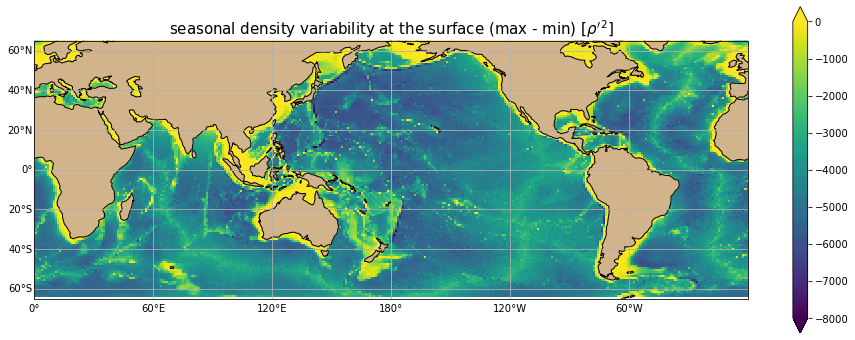

In [8]:
data_coords = {'latitude': RGlat, 'longitude': RGlon_c}
f, ax = plt.subplots(1,1,figsize=(16,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
xda = xr.DataArray(data=H_topo, dims=['latitude', 'longitude'], coords=data_coords) 
xda = xda.sortby('longitude')
xdap = xda.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), add_colorbar=True, vmin=-8000, vmax=0)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title(r"seasonal density variability at the surface (max - min) [$\rho ' ^2$]",fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_ylim([-65, 65])

(-65.0, 65.0)

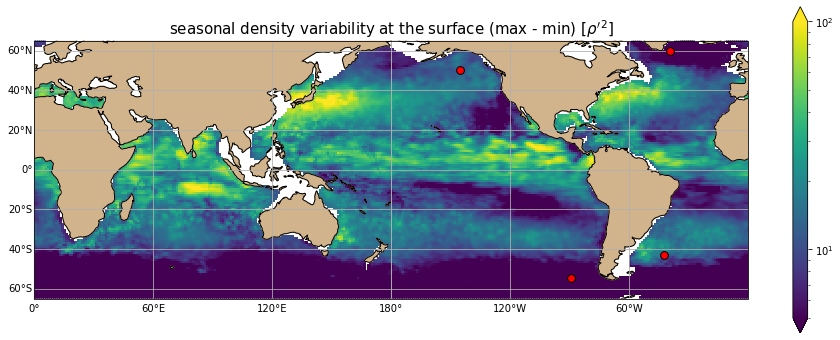

In [123]:
# f, ax = plt.subplots(1,1,figsize=(3,5))
# ax.plot(dep_var[:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], RGz, color='b')
data_coords = {'latitude': RGlat, 'longitude': RGlon_c}
f, ax = plt.subplots(1,1,figsize=(16,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
xda = xr.DataArray(data=tot_var, dims=['latitude', 'longitude'], coords=data_coords) 
xda = xda.sortby('longitude')
xdap = xda.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('viridis'), \
                add_colorbar=True, norm=LogNorm(vmin=5, vmax=100))
for i in range(len(stations)):
    ax.scatter(sta_lon[i], sta_lat[i], s=60,transform=ccrs.PlateCarree(),zorder=3,edgecolors='k',color='r')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title(r"seasonal density variability at the surface (max - min) [$\rho ' ^2$]",fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_ylim([-65, 65])
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_12_03/surface_density_var.jpg', dpi=250)

(-65.0, 65.0)

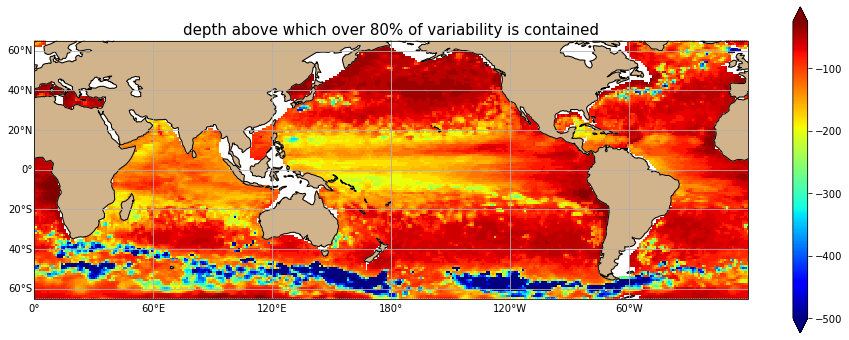

In [124]:
f, ax = plt.subplots(1,1,figsize=(16,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
xda = xr.DataArray(data=dep_seas, dims=['latitude', 'longitude'], coords=data_coords) 
xda = xda.sortby('longitude')
xdap = xda.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), \
                add_colorbar=True, vmin=-500, vmax=-25) 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('depth above which over 80% of variability is contained',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_ylim([-65, 65])
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_12_03/depth_of_density_var.jpg', dpi=250)

In [21]:
np.shape(density)

(12, 58, 145, 360)

In [11]:
rho = np.concatenate((density[:,:,:,RGlon_c < 20],density[:,:,:,RGlon_c > 20]),axis=3)
RGlon_c2 = np.concatenate((RGlon_c[RGlon_c < 20], RGlon_c[RGlon_c > 20]), axis=0)

In [155]:
# N2 = np.concatenate((N2[:,:,:,RG_shift], N2[:,:,:,0:RG_shift[0]]), axis=3)
# sigma = np.concatenate((density[:,:,:,RG_shift], density[:,:,:,0:RG_shift[0]]), axis=3)

In [2]:
# # -- Roemmich and Gilson Argo (load densities ... code to calulate is above) 
# filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_sigma0_N2_to_2000m.nc')
# argo_rho = xr.open_dataset(filename)
# RGN2 = argo_rho['N2'].data
# RGsigma = argo_rho['density'].data
# RGlon = argo_rho.lon.longitude.data
# RGlat = argo_rho.lat.latitude.data
# RGpressure = argo_rho.pressure.pressure.data
# RGz = gsw.z_from_p(RGpressure, 45) 
# # note: just choosing some lat (error due to this = the second decimal place in depth units... in the upper 1000m)

# # shift RG, MLD by longitude 
# RG_shift = np.where(RGlon > 360)[0]
# RGlon = np.concatenate((np.arange(0.5,20.5,1), RGlon[0:RG_shift[0]]))
# RGN2 = np.concatenate((RGN2[:,:,:,RG_shift], RGN2[:,:,:,0:RG_shift[0]]), axis=3)
# RGsigma = np.concatenate((RGsigma[:,:,:,RG_shift], RGsigma[:,:,:,0:RG_shift[0]]), axis=3)

In [27]:
np.shape(rho)

(12, 58, 145, 360)

In [12]:
# simply convolution to smooth N2 remove any negative values in/near the mixed layer
# filt_len = 6 # number of grid points to smooth over 
# box = np.ones(filt_len)/filt_len
fitd0 = -10; fitd1 = -400;
# fit_ind = np.where((N2z[:,0,0] < fitd0) & (N2z[:,0,0] > fitd1))
fit_ind = np.where((RGz < fitd0) & (RGz > fitd1))
decay = np.nan * np.ones((np.shape(N2)[0], np.shape(N2)[2], np.shape(N2)[3]))
misfit = np.nan * np.ones((np.shape(N2)[0], np.shape(N2)[2], np.shape(N2)[3]))
integral = np.nan * np.ones((np.shape(N2)[0], np.shape(N2)[2], np.shape(N2)[3]))
N2_adj = np.nan * np.ones(np.shape(N2))
rho_fit = np.nan * np.ones(np.shape(density))
for m in tqdm(range(np.shape(N2)[0])):
    for i in range(np.shape(N2)[2]):
        for j in range(np.shape(N2)[3]):
            this_N2 = (-1)*(rho[m,:,i,j].copy() - np.nanmax(rho[m,:,i,j].copy())) # (9.81/1030)*
            nancheck = np.where(this_N2 <= 0)[0]
            if len(nancheck) > 0: 
                upper_ocean_pos = np.where(this_N2[0:5] > 0)
                this_N2[nancheck] = np.nanmean(this_N2[upper_ocean_pos])
            # p = np.polyfit(N2z[fit_ind,0,0][0], np.log(this_N2[fit_ind]), 1)
            p = np.polyfit(RGz[fit_ind], np.log(this_N2[fit_ind]), 1)
            decay[m,i,j] = 1/p[0]
            rho_fit[m,:,i,j] = (-1 * np.exp(p[0] * RGz + p[1])) + np.nanmax(density[m,:,i,j].copy())
            # this_N2_fit = 1 * np.exp(p[0] * N2z[:,0,0][0] + p[1])
            # misfit[m,i,j] = np.nansum((this_N2 - this_N2_fit)**2)
            # integral[m,i,j] = np.trapz(this_N2[fit_ind],x=np.abs(N2z[fit_ind,0,0][0]))
            # N2_adj[m,:,i,j] = this_N2

In [68]:
np.shape(rho)

(12, 58, 145, 360)

In [71]:
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/CPT/Argo/Argo_rho_decay_dep_2018.nc')
ds = xr.Dataset(
    data_vars=dict(
        density=(["month","pressure","lat","lon"], rho),
        decay=(["month","lat","lon"], decay),
        depth=(["lat","lon"], np.abs(H_topo)),
    ),
    coords=dict(
        pressure=(["pressure"], argo_s.PRESSURE.data),
        month=(["month"], np.arange(1,13)),
        latitude=(["lat"], RGlat),
        longitude=(["lon"], RGlon_c2),
    ),
)
ds.to_netcdf(path=filename)

In [ ]:
# # Fit a polynomial of degree 1 (a linear function) to the data
# p = np.polyfit(x, np.log(y), 1)
# # Convert the polynomial back into an exponential
# a = np.exp(p[1])
# b = p[0]
# x_fitted = np.linspace(np.min(x), np.max(x), 100)
# y_fitted = a * np.exp(b * x_fitted)

In [298]:
stations = ['SO', 'ArgB', 'Irm', 'PAPA']
sta_lon = [360-89.24, 360-42.4985, 360-39.4818, 360 - 145.398]
sta_lat = [-54.47, -42.98167, 59.9753, 50.3]

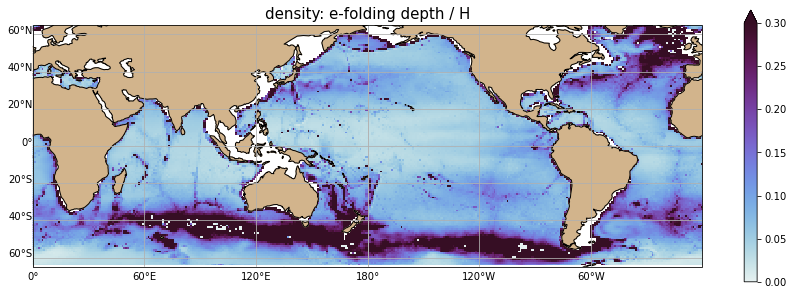

In [35]:
data_coords = {'latitude': RGlat, 'longitude': RGlon_c2}
f, ax = plt.subplots(1,1,figsize=(15,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
xda = xr.DataArray(data=(np.nanmean(decay,axis=0))/np.abs(H_topo),dims=['latitude', 'longitude'], coords=data_coords) 
# xda = xr.DataArray(data=rho[0,0],dims=['latitude', 'longitude'], coords=data_coords) 
# xda = xda.sortby('longitude')
xdap = xda.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.cm.dense, add_colorbar=True, vmin=0, vmax=0.3, extend='max')
# xdap = xda.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('magma_r'),add_colorbar=True, vmin=20, vmax=30)
# for i in range(len(stations)):
#     ax.scatter(sta_lon[i], sta_lat[i], s=70,transform=ccrs.PlateCarree(),zorder=3, edgecolors='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True)
ax.set_title('density: e-folding depth / H',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False
ax.set_ylim([-65, 65])
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2022_08_09/density_decay.jpg', dpi=250)

In [29]:
mi1 = 0
mi2 = 8
lon_in = np.where((RGlon_c > 160) & (RGlon_c < 230))[0] # 160-180
lat_in = np.where((RGlat > -60) & (RGlat < 40))[0]
this_i1 = 0
this_j1 = 0

# OG lat/lon
print('LOC 1')
offset0 = 92 # LAT   # 76
offset1 = 0  # LON 
print('[' + str(RGlon_c[lon_in[this_j1+offset1]]) + 'E, ' + str(RGlat[lat_in[this_i1+offset0]]) + 'N]')
print('Feb:')
p1w = np.polyfit(N2z[fit_ind,0,0][0], np.log(N2_adj[mi1][fit_ind][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]]), 1)
N2_fitted_1_w = 1 * np.exp(p1w[0] * N2z[:,0,0] + p1w[1])
print(p1w[0])
print('Aug:')
p1s = np.polyfit(N2z[fit_ind,0,0][0], np.log(N2_adj[mi2][fit_ind][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]]), 1)
N2_fitted_1_s = 1 * np.exp(p1s[0] * N2z[:,0,0] + p1s[1])
print(p1s[0])

# comparison lat/lon
print('LOC 2')
offset2 = 92
offset3 = 50
print('[' + str(RGlon_c[lon_in[this_j1+offset3]]) + 'E, ' + str(RGlat[lat_in[this_i1+offset2]]) + 'N]')
print('winter')
p2w = np.polyfit(N2z[fit_ind,0,0][0], np.log(N2_adj[mi1][fit_ind][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]]), 1)
N2_fitted_2_w = 1 * np.exp(p2w[0] * N2z[:,0,0] + p2w[1])
print(p2w[0])
print('summer')
p2s = np.polyfit(N2z[fit_ind,0,0][0], np.log(N2_adj[mi2][fit_ind][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]]), 1)
N2_fitted_2_s = 1 * np.exp(p2s[0] * N2z[:,0,0] + p2s[1])
print(p2s[0])

LOC 1
[160.5E, 32.5N]
Feb:
-0.0009312760970393129
Aug:
0.003065535461254932
LOC 2
[210.5E, 32.5N]
winter
0.000247061369598493
summer
0.0030697614630477033


## Goal
- chacterize the vertical structure of N$^2$, its decay and temporal variability
- question: how is eddy vertical structure (the vertical partitioning of KE/PE) controlled/moderated by background stratification 
- hypothesis: where stratification is strong and surface intensified eddy energy is surface intensified, transfers of energy among modes is confined to high baroclinic modes, and bottom dissipation is relatively weak 
- add on: this is doubly true for regions of steep/rough topography where sloping bottom modes are relevant ... implying a decay of horizontal velocity with depth 

## Procedure
- with Roemmich and Gilson 15 year gridded T/S maps, calculate N$^2$
- for one seasonal cycle fit an exponential at each grid point ($a e^{b z}$)
- ask: what are the spatial patterns of this fit and how does it vary in time? 
- ask: how well does an exponential profile represent the actual profile 

- additional calculations: horizontal buoyancy gradients 
- use these fields to interpret vertical structure at OOI moorings sites 

larger values (reds) correspond to surface intensified stratification


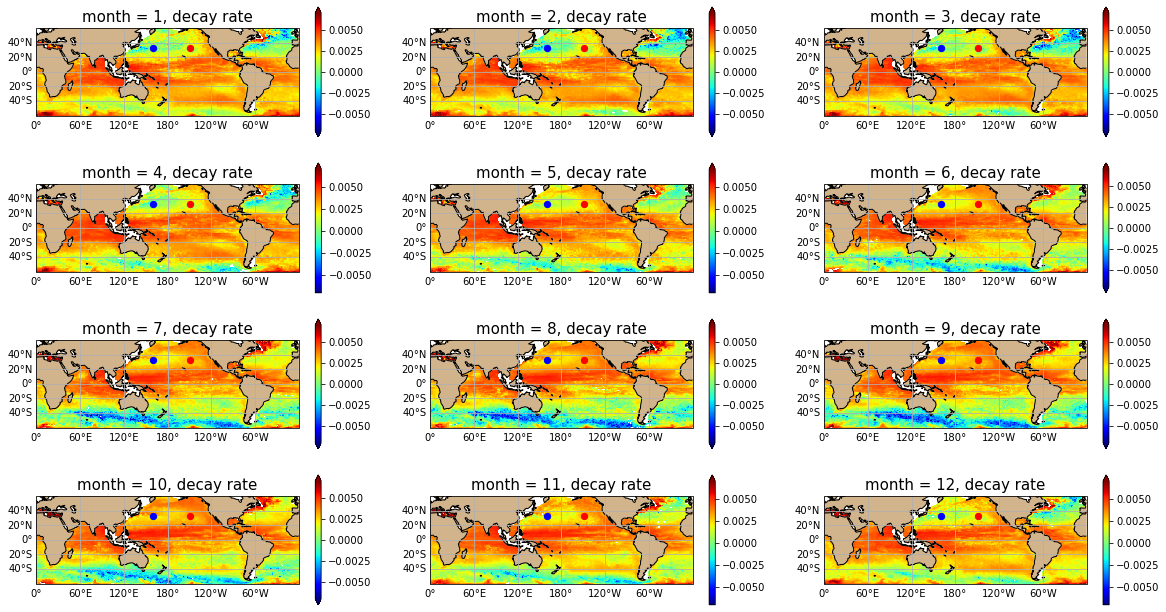

In [31]:
this_t = range(0,12) # range(t_indices[0], t_indices[1])
data_coords = {'latitude': RGlat, 'longitude': RGlon_c}
f, ax = plt.subplots(4,3,figsize=(20,11), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
gax = ax.flatten()
for i in range(len(gax)):
    ii = this_t[i]
    xda = xr.DataArray(data=decay[ii], dims=['latitude', 'longitude'], coords=data_coords) 
    xda = xda.sortby('longitude')
    xdap = xda.plot(ax=gax[i],transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), \
                    add_colorbar=True, vmin=-0.007, vmax=0.007) 
    gax[i].scatter(RGlon_c[lon_in[this_j1+offset1]], RGlat[lat_in[this_i1+offset0]], color='b', \
               s=40,transform=ccrs.PlateCarree(),zorder=3)
    gax[i].scatter(RGlon_c[lon_in[this_j1+offset3]], RGlat[lat_in[this_i1+offset2]], color='r', \
               s=40,transform=ccrs.PlateCarree(),zorder=3)
    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    gl = gax[i].gridlines(draw_labels=True)
    gax[i].set_title('month = ' + str(i+1) + ', decay rate',fontsize=15)
    gl.xlabels_top = False; gl.ylabels_right = False; gax[i].set_ylim([-60, 60])
print('larger values (reds) correspond to surface intensified stratification')
# f.savefig('/Users/jakesteinberg/Desktop/n2_decay.jpg', dpi=400)

In [34]:
mi1 = 0
mi2 = 8
lon_in = np.where((RGlon_c > 160) & (RGlon_c < 230))[0] # 160-180
lat_in = np.where((RGlat > -60) & (RGlat < 40))[0]
offset0 = 92 # LAT   # 76
offset1 = 0  # LON 
offset2 = 92
offset3 = 50

(57,)

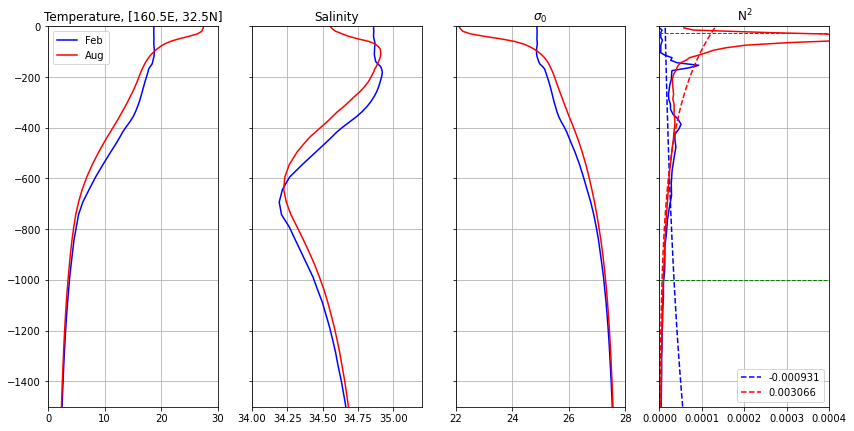

In [76]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(14,7),sharey=True)
ax1.plot(CT[mi1][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], RGz, color='b', label='Feb')
ax2.plot(SA[mi1][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], RGz, color='b')
ax3.plot(density[mi1][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], RGz, color='b')
ax1.plot(CT[mi2][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], RGz, color='r', label='Aug')
ax2.plot(SA[mi2][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], RGz, color='r')
ax3.plot(density[mi2][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], RGz, color='r')

ax4.plot(N2_adj[mi1][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], N2z[:,0,0], color='b')
ax4.plot(N2_fitted_1_w, N2z[:,0,0], color='b', linestyle='--', label=str(np.round(p1w[0],6)))
ax4.plot(N2_adj[mi2][:,lat_in[this_i1+offset0]][:, lon_in[this_j1+offset1]], N2z[:,0,0], color='r')
ax4.plot(N2_fitted_1_s, N2z[:,0,0], color='r', linestyle='--', label=str(np.round(p1s[0],6)))
ax4.plot([0,0.0005],[fitd0, fitd0], color='g', linestyle='--', linewidth=1); ax4.plot([0,0.0005],[fitd1, fitd1], color='g', linestyle='--', linewidth=1)
ax1.set_xlim([0,30]); ax2.set_xlim([34, 35.2]); ax3.set_xlim([22, 28]); ax4.set_xlim([0, 0.0004]); ax1.set_ylim([-1500, 0]); ax1.legend(); ax4.legend();
ax1.set_title('Temperature, ' + '[' + str(RGlon_c[lon_in[this_j1+offset1]]) + 'E, ' + str(RGlat[lat_in[this_i1+offset0]]) + 'N]' )
ax2.set_title('Salinity'); ax3.set_title('$\sigma_0$'); ax4.set_title('N$^2$'); ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid();
# f.savefig('/Users/jakesteinberg/Desktop/n2_decay_2sites_nep_m8.jpg', dpi=300)

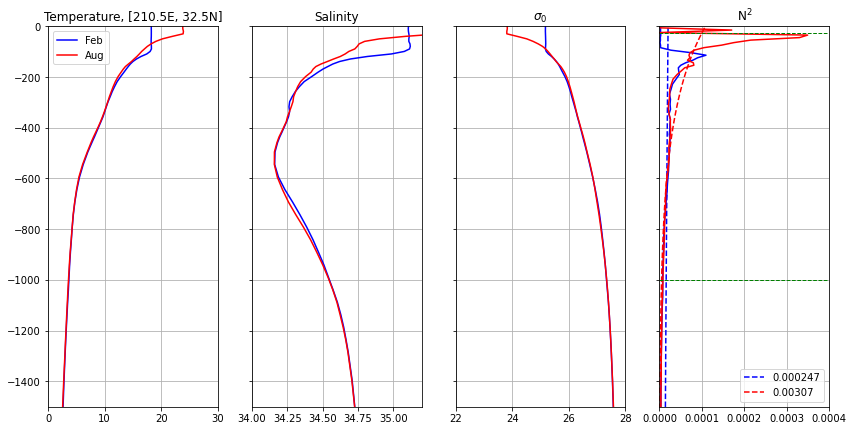

In [75]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(14,7),sharey=True)
ax1.plot(CT[mi1][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], RGz, color='b', label='Feb')
ax2.plot(SA[mi1][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], RGz, color='b')
ax3.plot(density[mi1][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], RGz, color='b')
ax4.plot(N2_adj[mi1][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], N2z[:,0,0], color='b')
ax4.plot(N2_fitted_2_w, N2z[:,0,0], color='b', linestyle='--', label=str(np.round(p2w[0],6)))
ax1.plot(CT[mi2][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], RGz, color='r', label='Aug')
ax2.plot(SA[mi2][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], RGz, color='r')
ax3.plot(density[mi2][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], RGz, color='r')
ax4.plot(N2_adj[mi2][:,lat_in[this_i1+offset2]][:, lon_in[this_j1+offset3]], N2z[:,0,0], color='r')
ax4.plot(N2_fitted_2_s, N2z[:,0,0], color='r', linestyle='--',label=str(np.round(p2s[0],6)))
ax4.plot([0,0.0005],[fitd0, fitd0], color='g', linestyle='--', linewidth=1); ax4.plot([0,0.0005],[fitd1, fitd1], color='g', linestyle='--', linewidth=1)
ax1.set_xlim([0,30]); ax2.set_xlim([34, 35.2]); ax3.set_xlim([22, 28]); ax4.set_xlim([0, 0.0004]); ax1.set_ylim([-1500, 0]); ax1.legend(); ax4.legend();
ax1.set_title('Temperature, ' + '[' + str(RGlon_c[lon_in[this_j1+offset3]]) + 'E, ' + str(RGlat[lat_in[this_i1+offset2]]) + 'N]' )
ax2.set_title('Salinity'); ax3.set_title('$\sigma_0$'); ax4.set_title('N$^2$'); ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid()
# f.savefig('/Users/jakesteinberg/Desktop/n2_decay_2sites_nep_m8.jpg', dpi=300)

In [136]:
stations = ['SO', 'ArgB', 'Irm', 'PAPA']
sta_lon = [360-89.24, 360-42.4985, 360-39.4818, 360 - 145.398]
sta_lat = [-54.47, -42.98167, 59.9753, 50.3]

(-65.0, 65.0)

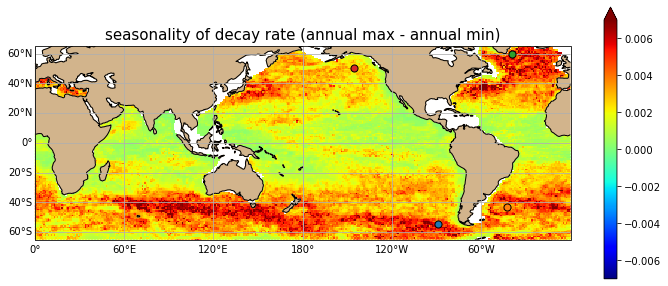

In [82]:
f, ax = plt.subplots(1,1,figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
tp = np.nanmax(decay,axis=0) - np.nanmin(decay, axis=0)
xda = xr.DataArray(data=tp, dims=['latitude', 'longitude'], coords=data_coords) 
xda = xda.sortby('longitude')
xdap = xda.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), \
                add_colorbar=True, vmin=-0.007, vmax=0.007) 
for i in range(len(stations)):
    ax.scatter(sta_lon[i], sta_lat[i], s=50,transform=ccrs.PlateCarree(),zorder=3, edgecolors='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
ax.set_title('seasonality of decay rate (annual max - annual min)',fontsize=15)
gl.xlabels_top = False
gl.ylabels_right = False
ax.set_ylim([-65, 65])

In [269]:
rho_fit[mi][:,la_i[2]][:, lo_i[2]]

array([26.42898306, 26.44229743, 26.45983927, 26.47714336, 26.49421294,
       26.5110512 , 26.52766129, 26.5440463 , 26.5602093 , 26.57615331,
       26.5918813 , 26.60739621, 26.62270094, 26.63779835, 26.65269125,
       26.66738243, 26.68187462, 26.69617054, 26.71376848, 26.73790711,
       26.76479805, 26.79096572, 26.81642965, 26.84120883, 26.86532173,
       26.88878634, 26.91162014, 26.93384016, 26.95546294, 26.9765046 ,
       26.99698082, 27.01690683, 27.03868438, 27.07353   , 27.11730819,
       27.15820629, 27.19641444, 27.23211013, 27.26545912, 27.29661622,
       27.32572595, 27.35292331, 27.37833433, 27.40207675, 27.42426048,
       27.44498819, 27.46435577, 27.48245275, 27.49936278, 27.51516395,
       27.52992921, 27.54703243, 27.56866877, 27.59045048, 27.60947352,
       27.62608833, 27.64060071, 27.65026712])

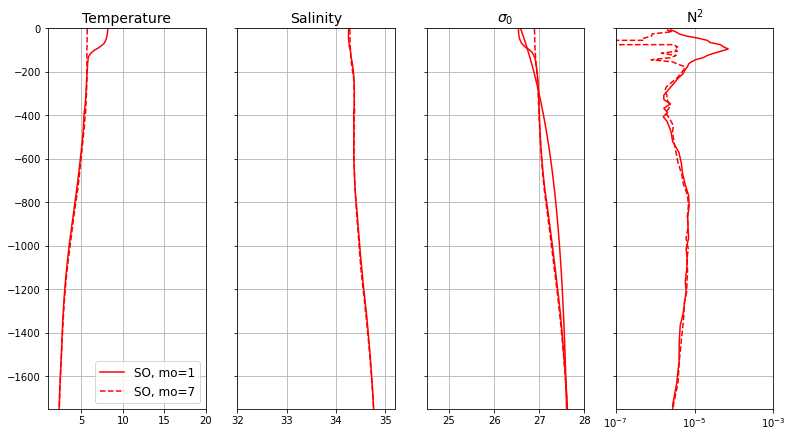

In [321]:
mi = 0
colors = 'r', 'g', 'y', 'b'
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(13,7), sharey=True)
for i in [0]:
    lo_i = np.where((RGlon_c > (sta_lon[i] - 1.5)) & (RGlon_c < (sta_lon[i] + 1.5)))[0] # 160-180
    la_i = np.where((RGlat > (sta_lat[i] - 1.5)) & (RGlat < (sta_lat[i] + 1.5)))[0]
    ax1.plot(CT[mi][:,la_i[2]][:, lo_i[2]], RGz, label=stations[i] + ', mo=' + str(mi+1), color=colors[i])
    ax2.plot(SA[mi][:,la_i[2]][:, lo_i[2]], RGz, color=colors[i])
    ax3.plot(density[mi][:,la_i[2]][:, lo_i[2]], RGz, color=colors[i])
    ax3.plot(rho_fit[mi][:,la_i[2]][:, lo_i[2]], RGz, color=colors[i])
    ax4.plot(N2[mi][:,la_i[2]][:, lo_i[2]], N2z[:,0,0], color=colors[i])
for i in [0]:
    lo_i = np.where((RGlon_c > (sta_lon[i] - 1.5)) & (RGlon_c < (sta_lon[i] + 1.5)))[0] # 160-180
    la_i = np.where((RGlat > (sta_lat[i] - 1.5)) & (RGlat < (sta_lat[i] + 1.5)))[0]
    ax1.plot(CT[mi+6][:,la_i[2]][:, lo_i[2]], RGz, label=stations[i] + ', mo=' + str(mi+6+1), linestyle='--', color=colors[i])
    ax2.plot(SA[mi+6][:,la_i[2]][:, lo_i[2]], RGz,linestyle='--', color=colors[i])
    ax3.plot(density[mi+6][:,la_i[2]][:, lo_i[2]], RGz,linestyle='--', color=colors[i])
    ax4.plot(N2[mi+6][:,la_i[2]][:, lo_i[2]], N2z[:,0,0],linestyle='--', color=colors[i])
ax4.set_xscale('log'); 
ax1.legend(fontsize=12); ax1.grid(); ax2.grid(); ax3.grid(); ax4.grid(); ax1.set_ylim([-1750, 0])   
ax1.set_xlim([1, 20]); ax2.set_xlim([32, 35.2]); ax3.set_xlim([24.5,28]); ax4.set_xlim([0.0000001, 0.001])
ax1.set_title('Temperature',fontsize=14)
ax2.set_title('Salinity',fontsize=14); ax3.set_title('$\sigma_0$',fontsize=14); ax4.set_title('N$^2$',fontsize=14);
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_12_03/density_profs_papa.jpg', dpi=250)

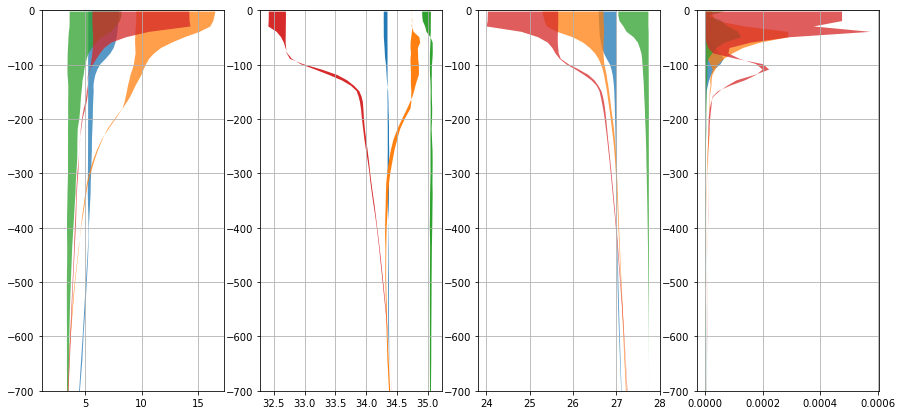

In [39]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,7))
for i in range(len(stations)):
    lo_i = np.where((RGlon_c > (sta_lon[i] - 1)) & (RGlon_c < (sta_lon[i] + 1)))[0] # 160-180
    la_i = np.where((RGlat > (sta_lat[i] - 1)) & (RGlat < (sta_lat[i] + 1)))[0]
    
    this_rho = density[:,:,la_i[0],lo_i[0]]
    winn = np.where(np.nanmean(this_rho[:, 0:5], axis=1) == np.nanmax(np.nanmean(this_rho[:, 0:5], axis=1)))[0][0]
    summ = np.where(np.nanmean(this_rho[:, 0:5], axis=1) == np.nanmin(np.nanmean(this_rho[:, 0:5], axis=1)))[0][0]
    
    ax1.fill_betweenx(RGz, CT[summ][:,la_i[0]][:, lo_i[0]], CT[winn][:,la_i[0]][:, lo_i[0]], alpha=0.75)
    ax2.fill_betweenx(RGz, SA[summ][:,la_i[0]][:, lo_i[0]], SA[winn][:,la_i[0]][:, lo_i[0]], alpha=0.99)
    ax3.fill_betweenx(RGz, density[summ][:,la_i[0]][:, lo_i[0]], density[winn][:,la_i[0]][:, lo_i[0]], alpha=0.75)
    ax4.fill_betweenx(RGz, N2_adj[summ][:,la_i[0]][:, lo_i[0]], N2_adj[winn][:,la_i[0]][:, lo_i[0]], alpha=0.75)
ax1.set_ylim([-700, 0])
ax2.set_ylim([-700, 0])
ax3.set_ylim([-700, 0])
ax4.set_ylim([-700, 0])
ax1.grid()
ax2.grid()    
ax3.grid()
ax4.grid()

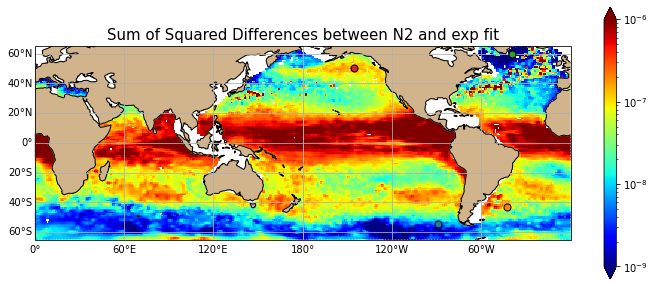

In [137]:
f, ax = plt.subplots(1,1,figsize=(12,5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
xda = xr.DataArray(data=misfit[168], dims=['latitude', 'longitude'], coords=data_coords) 
xda = xda.sortby('longitude')
xdap = xda.plot(ax=ax,transform=ccrs.PlateCarree(), cmap=plt.get_cmap('jet'), add_colorbar=True, \
                norm=LogNorm(vmin=0.000000001,vmax=0.000001))
for i in range(len(stations)):
    ax.scatter(sta_lon[i], sta_lat[i], s=50,transform=ccrs.PlateCarree(),zorder=3, edgecolors='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines(); gl = ax.gridlines(draw_labels=True);
ax.set_title('Sum of Squared Differences between N2 and exp fit',fontsize=15)
gl.xlabels_top = False; gl.ylabels_right = False; ax.set_ylim([-65, 65]);